Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW10.ipynb`
- `model_config.yaml`
- `train_config.yaml`
- `state_dict.pt`

In [116]:
import os
from typing import Union, Dict
from tqdm import tqdm
import numpy as np

# plotting:
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.autolayout': True})

# new package for loading data
try:
    import h5py
except ImportError:
    os.system('pip install h5py -qq')
    import h5py

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from HW10_utils import Tracker

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

Device is cpu


# scaled dot-product attention in `numpy` (20)

First, you will implement the central operation of the transformer, i.e. the scaled_dot_product_attention using `numpy`. You will use the function from PyTorch to test your implementation, so you can easily test it before submission.

To better understand what is happening, write the shape of each array as a comment.

You may find `.swapaxes()` and `.tril()` useful.

In [117]:
# AUTOGRADED

def softmax(z: np.ndarray):
    """
    Applies softmax along the last dimension
    """
    z -= np.max(z, axis=-1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=-1, keepdims=True)


def scaled_dot_product_attention(
        query: np.ndarray, # (N, H, L, E)
        key: np.ndarray, # (N, H, S, E)
        value: np.ndarray, # (N, H, S, Ev)
        attn_mask: Union[np.ndarray, None] = None, # (L, S) boolean mask
        is_causal: bool = False,
        ) -> np.ndarray: # (N, H, L, Ev)
    """
    attn_mask is assumed to be boolean array of shape (L, S).
    Where False, the corresponding attention element is omitted.
    """
    
    # perform the dot product between query and key
    N, H, L, E = query.shape
    _, _, S,  _ = key.shape
    _, _, S2, Ev = value.shape

    scores = np.matmul(query, key.transpose(0, 1, 3, 2)) # (N, H, L, S)

    # where attn_mask is False, set the attention values to -np.inf
    if attn_mask is not None:
        scores = np.where(attn_mask[None, None, :, :], scores, -np.inf)

    # if causal, set the upper triangular part to -np.inf
    if is_causal:
        assert attn_mask is None, 'Cannot use both causal and attn_mask'
        # create a causal mask and apply it similarly to how the attn_mask was applied
        causal_mask = np.triu(np.ones((L, S), dtype=bool), k=1)
        scores = np.where(causal_mask[None,None,:,:], -np.inf, scores)

    # scale the attention values by square root of E
    scores /= np.sqrt(E)

    # apply softmax to the last dimension
    attn_weights = softmax(scores) # (N, H, L, S)

    # multiply attention with the value
    # return the result
    return np.matmul(attn_weights, value) # (N, H, L, Ev)

In [118]:
from HW10_utils import test_sdpa

test_sdpa(scaled_dot_product_attention)

Test 1: N=3, H=8, S=7, L=12, E=5, Ev=7 --> PASSED
----------------------------------------------------------------------
Test 2: N=7, H=9, S=2, L=3, E=9, Ev=3 --> PASSED
----------------------------------------------------------------------
Test 3: N=6, H=6, S=6, L=10, E=7, Ev=2 --> PASSED
----------------------------------------------------------------------
Test 4: N=6, H=1, S=7, L=11, E=9, Ev=3 --> PASSED
----------------------------------------------------------------------
Test 5: N=3, H=6, S=8, L=13, E=9, Ev=3, with mask --> PASSED
----------------------------------------------------------------------
Test 6: N=9, H=1, S=8, L=11, E=3, Ev=3, with mask --> PASSED
----------------------------------------------------------------------
Test 7: N=7, H=7, S=1, L=1, E=9, Ev=6, with mask --> PASSED
----------------------------------------------------------------------
Test 8: N=9, H=9, S=2, L=2, E=3, Ev=6, causal --> PASSED
-----------------------------------------------------------------

## Multihead Attention in `numpy` (20)

Now that you have implemented the scaled dot-product attention, you can implement the forward pass of a multihead attention layer using `numpy`. You may find `.swapaxes()` and `.reshape()` useful. Also, remember that the mask is treated in the opposite way now, so you should reverse it when passing it to your numpy `scaled_dot_product_attention` if it is not `None`. 

Note: remember that for `nn.MultiheadAttention` from PyTorch, you still need to pass the `attn_mask` for a causal attention, and `is_causal` only acts as a hint to the module about the `attn_mask`, which you do need to provide explicitly. Therefore, the numpy function you are going to implement does not have that argument, and you need to define a causal mask if you want it to perform a causal attention. You have to do the same thing when using the forward pass of `nn.MultiheadAttention`.

In [119]:
# AUTOGRADED

def MultiheadAttention(
        query_target: np.ndarray, # (N, L, E)
        key_source: np.ndarray, # (N, S, kdim)
        value_source: np.ndarray, # (N, S, vdim)
        num_heads: int,
        params: Dict[str, np.ndarray], # dict of weights
        attn_mask: Union[np.ndarray, None] = None, # (L, S) boolean mask
        ) -> np.ndarray: # (N, L, E)
    """
    attn_mask is assumed to be boolean array of shape (L, S).
    Where True, the corresponding attention element is omitted.

    params: dictionary containing the following keys
        Wq: weight matrix of shape (E, E)
        Wk: weight matrix of shape (kdim, E)
        Wv: weight matrix of shape (vdim, E)
        Wo: weight matrix of shape (E, E)
    """
    assert query_target.shape[-1] % num_heads == 0, 'Dimension should be divisible by nhead'

    # You may find these useful to reshape the tensors
    N, L, E = query_target.shape
    N, S, kdim = key_source.shape
    N, S, vdim = value_source.shape
    head_dim = E // num_heads
    

    # compute the query, key, and value projections
    q = np.matmul(query_target, params['Wq']) # (N, L, E)
    k = np.matmul(key_source, params['Wk']) # (N, S, E)
    v = np.matmul(value_source, params['Wv']) # (N, S, Ev)

    # reshape the arrays to split the feature dimension into num_heads groups (heads)
    # then, order the axes properly for the scaled_dot_product_attention call
    # so you can pass them to scaled_dot_product_attention
    q = q.reshape(N, L, num_heads, head_dim).transpose(0, 2, 1, 3) # (N, H, L, E/H)
    k = k.reshape(N, S, num_heads, head_dim).transpose(0, 2, 1, 3) # (N, H, S, E/H)
    v = v.reshape(N, S, num_heads, head_dim).transpose(0, 2, 1, 3) # (N, H, S, E/H)

    # if the attention mask is not None, reshape it to match the query and key dimensions
    if attn_mask is not None:
        attn_mask = ~attn_mask

    # execute scaled dot product attention with your function from before
    attn_out = scaled_dot_product_attention(
        query=q, # (N, H, L, E/H)
        key=k, # (N, H, S, E/H)
        value=v, # (N, H, S, Ev)
        attn_mask=attn_mask,
        is_causal=False,
    ) # (N, H, L, Ev)

    # merge the heads back together
    attn_out = attn_out.transpose(0, 2, 1, 3).reshape(N, L, E) # (N, L, E)

    # apply the final linear transformation
    attn_out = np.matmul(attn_out, params['Wo']) # (N, L, E)

    return attn_out # (N, L, E)

In [120]:
from HW10_utils import test_mha

test_mha(MultiheadAttention)

Test 1: N=5, S=9, L=13, E=16, kdim=9, vdim=5, H=4 --> PASSED
----------------------------------------------------------------------
Test 2: N=2, S=6, L=10, E=32, kdim=6, vdim=4, H=8 --> PASSED
----------------------------------------------------------------------
Test 3: N=1, S=5, L=8, E=8, kdim=4, vdim=4, H=1 --> PASSED
----------------------------------------------------------------------
Test 4: N=4, S=5, L=9, E=8, kdim=3, vdim=4, H=8 --> PASSED
----------------------------------------------------------------------
Test 5: N=1, S=3, L=3, E=8, kdim=1, vdim=1, H=4 --> PASSED
----------------------------------------------------------------------
Test 6: N=8, S=9, L=16, E=32, kdim=3, vdim=8, H=4, with mask --> PASSED
----------------------------------------------------------------------
Test 7: N=4, S=9, L=14, E=16, kdim=8, vdim=7, H=8, with mask --> PASSED
----------------------------------------------------------------------
Test 8: N=1, S=8, L=10, E=32, kdim=5, vdim=2, H=2, with mask

# Train a transformer to simulate a 1D PDE (60)

In this section, you will umplement a decoder-only transformer to predict the future time-steps of a system governed by a Partial Differential Equation (PDE). The dataset class is already provvided for you and you can visualize and investigate it using the interactive visualizer class. Your tasks are the following:

- Implement the positional encoding from the original transformer paper, to be added to the data at the beginning of the model's forward pass (10)

- Implement the forward pass of the decoder-only transformer layer. You will find further details in the relevant section (15)

- Implement an autoregressive method to predict future steps for the inference/evaluation stage (15)

- Find and train a model to achieve desirable error (10)

- Conclude the effect of the hyperparameters (10)



## Dataset 
First, we have provided you with a PDE dataset. The dataset contains the solution of the Burger's equation over time, on a discretized grid over time and space. The Burger's equation is defined as the following:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

where $\nu$ is the kinematic viscousity. In our dataset, the spatial domain is under periodic boundary conditions, and each sample trajectory starts from a random initail condition. The domains and the parameters of the PDE are as follows:
$$
x \in [0, 1) \quad t \in [0, 1] \quad \nu = 0.01
$$
and the spatial and temporal domain are discretized into 128 and 51 points respectively. The original dataset was provided by [this paper](https://arxiv.org/abs/2010.08895), and we have prepared a downsampled version of it for this assignment.

In [121]:
class Burgers_Dataset(Dataset):

    def __init__(
            self,
            data_path: str = 'data/Train_Burgers_v1e-2_N1792_T1_tr50_X1_xr128.hdf5',
            device: str = 'cpu',
            ):
        super().__init__()

        # load the data
        with h5py.File(data_path, 'r') as file:
            self.u = torch.tensor(file['u'][:], dtype=torch.float32, device=device) # (N, rt, rx)
            self.t = torch.tensor(file['t-coordinate'][:], dtype=torch.float32, device=device)
            self.x = torch.tensor(file['x-coordinate'][:], dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.u)
    
    def __getitem__(self, idx):

        return self.u[idx]

In [122]:
def viz_burger(
    dataset: Burgers_Dataset,
    idx: int, 
    # For comparing model output:
    model: Union[None, nn.Module] = None,
    loss_fn: callable = F.mse_loss,
    n_starting_steps: int = 10,
    ):
    fig, ax = plt.subplots(
        1, 1 if model is None else 3,
        figsize = (4 if model is None else 12, 4),
        sharex = True, sharey = True,
        )

    if model is not None:
        model.eval().cpu()
        ax, ax_model, ax_diff = ax

    t, x = dataset.t, dataset.x
    u = dataset[idx:idx+1]

    # using pcolormesh to plot the data and sace the returned object to update with the widget
    true_im = ax.pcolormesh(
        x, t, u[0].cpu().numpy(), 
        cmap='seismic', vmin=-1, vmax=1)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title(f'data index: {idx}')


    fig.colorbar(true_im, ax=ax)

    if model is not None:

        model_input = u[:, :n_starting_steps, :]
        steps = u.shape[1] - n_starting_steps
        with torch.inference_mode():
            model_output = model.predict(model_input, steps=steps)
            loss = loss_fn(model_output, u[:, n_starting_steps:, :]).item()
            pred_u = torch.cat([model_input, model_output], dim=1)
            diff = pred_u - u

        pred_im = ax_model.pcolormesh(
            x, t, pred_u[0].cpu().numpy(), 
            cmap='seismic', vmin=-1, vmax=1)
        ax_model.set_xlabel('x')
        ax_model.set_ylabel('t')
        ax_model.set_title('Model Prediction')
        fig.colorbar(pred_im, ax=ax_model)

        diff_im = ax_diff.pcolormesh(
            x, t, diff[0].cpu().numpy(), 
            cmap='seismic', vmin=-1, vmax=1)
        ax_diff.set_xlabel('x')
        ax_diff.set_ylabel('t')
        ax_diff.set_title('Difference')
        fig.colorbar(diff_im, ax=ax_diff)
        ax_diff.set_title(f'Difference, loss: {loss:.4f}')

    fig.tight_layout()
    plt.show()

In [123]:
train_dataset = Burgers_Dataset()

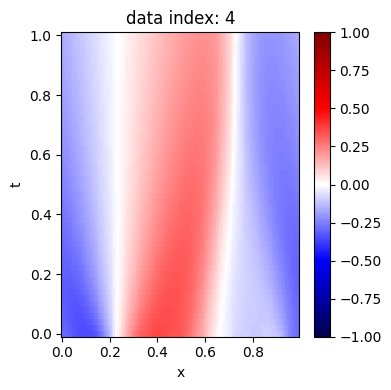

In [124]:
viz = viz_burger(train_dataset, idx=4)

## Positional Encoding (10)

Implement the positional encoding from the paper, to be added to the input of the transformer. According to the paper:

"""

In this work, we use sine and cosine functions of different frequencies:
$$
PE_{(pos, 2i)} = \sin \left( pos / 10000^{2i / d_{\text{model}}} \right)
$$

$$
PE_{(pos, 2i+1)} = \cos \left( pos / 10000^{2i / d_{\text{model}}} \right)
$$
where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000·2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

"""

In [125]:
# AUTOGRADED

def positional_encoding(
        embed_dim: int, # d_model in the formula
        max_len: int = 10000, # maximum length of the sequence (10000 in the formula)
        ) -> torch.FloatTensor: # (max_len, embed_dim)
    
    pe = torch.zeros(max_len, embed_dim, dtype=torch.float32)

    # create a tensor representing all i's and pos's using torch.arange
    # make sure the shapes are right so they can be broadcasted correctly.

    # shape (embed_dim//2,)
    # ranges from 0 to embed_dim//2
    i = torch.arange(embed_dim // 2, dtype=torch.float32)

    # shape (max_len, 1)
    pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)

    # calculate the angles (the argument to sine or cosine)
    # shape (max_len, embed_dim//2)
    angles = pos / torch.pow(max_len, (2 * i) / embed_dim)

    # fill in the even indices with sine and odd indices with cosine
    pe[:, 0::2] = torch.sin(angles) # even indices
    pe[:, 1::2] = torch.cos(angles) # odd indices

    return pe


## Implement the `forward` and `predict` methods (40)

Now you have to fill in the `forward` method of the TransformerLayer class. Remember that this is a decoder-only transformer, meaning that there is no cross-attention to some memory, and the self-attention is causal. You will need to provide the proper mask for a correct implementation. Refer to [this paper](https://arxiv.org/pdf/2002.04745) for hints to implement `forward` based on `self.norm_first`.

Next, you will implement the `predict` method which autoregressively predicts new steps. We start with the first 10 frames of the trajectory. Similar to the RNN assignment, the output sequence is supposed to be the input sequence shifted for one time-step. Therefore, each forward pass of the model will give you a new time-step at the end of its output. Your model input will therefore gradually increase in length with every new step that is predicted and appendded to it for the next step.

In [126]:
# AUTOGRADED

def FFN(dim: int = 128, bias: bool = False) -> nn.Module:
    """
    A simple feedforward network with GELU activation
    Used in the TransformerLayer
    """
    return nn.Sequential(
        nn.Linear(dim, dim*2, bias=bias),
        nn.GELU(),
        nn.Linear(dim*2, dim, bias=bias),
        )


def causal_attn_mask(
        x: torch.Tensor, # (B, nt, embed_dim)
        ) -> torch.BoolTensor: # (nt, nt)
    """
    where True, attention is omitted!
    """
    nt = x.shape[1]

    # return a causal mask

    return torch.triu(torch.ones((nt, nt), dtype=torch.bool), diagonal=1).to(x.device) # (nt, nt)


class TransformerLayer(nn.Module):

    def __init__(
            self,
            embed_dim: int = 128,
            num_heads: int = 4,
            norm_first: bool = False,
            bias: bool = False,
            ):
        super().__init__()

        self.norm_first = norm_first

        self.attn_ln = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            bias = bias,
            batch_first = True,
            )
        
        self.ffn_ln = nn.LayerNorm(embed_dim)
        self.ffn = FFN(embed_dim, bias=bias)

    def forward(
            self,
            x: torch.FloatTensor, # (B, nt, embed_dim)
            ) -> torch.FloatTensor: # (B, nt, embed_dim)
        """
        Implement the forward pass of the transformer decoder layer without the cross-attention.
        It is similar to the typical Transformer Encoder Layer, but with a causal self-attention!
        """

        # create the causal attention mask
        attn_mask = causal_attn_mask(x)

        # apply the attention layer
        if self.norm_first:
            x_res = x
            x_norm = self.attn_ln(x_res)
            y, _ = self.attn(x_norm, x_norm, x_norm, attn_mask=attn_mask) # (B, nt, embed_dim)
            x = x_res + y
        else:
            y, _ = self.attn(x, x, x, attn_mask=attn_mask) # (B, nt, embed_dim)
            x = self.attn_ln(x + y) # (B, nt, embed_dim)

        # apply the feedforward network    
        if self.norm_first:
            x_res = x
            x_norm = self.ffn_ln(x_res)
            y = self.ffn(x_norm)
            x = x_res + y
        else:
            x = self.ffn_ln(x + self.ffn(x)) # (B, nt, embed_dim)
        
        return x # (B, nt, embed_dim)
        

class Model(nn.Module):

    def __init__(
            self,
            n_layers: int = 6,
            embed_dim: int = 128,
            num_heads: int = 4,
            norm_first: bool = False,
            bias: bool = False,
            ):
        
        super().__init__()

        self.embed_in = nn.Sequential(
            nn.Linear(128, embed_dim, bias=bias),
            nn.LayerNorm(embed_dim),
            )

        self.layers = nn.Sequential(*[
            TransformerLayer(
                embed_dim = embed_dim,
                num_heads = num_heads,
                norm_first = norm_first,
                bias = bias,
                )
            for _ in range(n_layers)
        ])

        self.embed_out = nn.Linear(embed_dim, 128, bias=bias)

        self.register_buffer(
            'pos_enc',
            positional_encoding(
                max_len = 51,
                embed_dim = embed_dim,
            ),
            )

    def forward(
            self,
            x: torch.FloatTensor, # (B, nt, 128)
            ) -> torch.FloatTensor: # (B, nt, 128)
        """
        Tries to learn the shifted sequence for one-step.
        Will be used autoregressively in the predict method below.
        """
        # embed_in
        x = self.embed_in(x)

        # add positional encoding
        # slice self.pos_enc to get the time-steps corresponding to the input x
        # you can assume that the start time is 0
        x = x + self.pos_enc[:x.shape[1]]
        
        # transformer layers
        x = self.layers(x)

        # embed_out
        x = self.embed_out(x)

        return x

    def predict(
            self,
            x: torch.FloatTensor, # (B, n_starting_steps, 128)
            steps: int, # number of steps to predict
            ) -> torch.FloatTensor: # (B, steps, 128)
        """
        This is the function that is used in inference/evaluation.
        Since we would not have the whole sequence, we will predict the next step autoregressively.
        This means that at each step, we will predict the next step and append it to the input sequence.
        Therefore, the input to the model at each step will be the concatenation of the previous input and the new predicted step.
        """

        output = []

        for t in range(steps):

            # a forward pass of the transformer to shift the sequence by one time-step
            y = self.forward(x) # (B, nt, 128)

            # append the new predicted time-step to the output
            output.append(y[:, -1:, :]) # (B, 1, 128)

            # create the input for the next step by concatenating the current input
            # with the new predicted time-step.
            x = torch.cat([x, y[:, -1:, :]], dim=1) # (B, nt+1, 128)

        # stack or concatenate the predicted steps in the output list and return the tensor
        return torch.cat(output, dim=1) # (B, steps, 128)

## Training

As yet another reminder, we can use the whole sequence during training. However, we do not have access to the full trajectory in inference (evaluation) stage. Therefore, we start from several initial steps, and autoregressively predict future steps. Take a close look at the `eval_epoch` function to see how it works. This will be the final metric used to evaluate your model.

In [127]:
def rL2Loss(
        pred: torch.FloatTensor, # (B, nt, nx)
        target: torch.FloatTensor, # (B, nt, nx)
        norm_dim = (1, 2)
        ) -> torch.FloatTensor: # ()
    """
    relative L2 loss. A common loss used for PDE data.
    """
    error = pred - target
    error_norm = error.norm(dim=norm_dim, p=2)
    target_norm = target.norm(dim=norm_dim, p=2)
    return (error_norm / target_norm).mean()


@torch.enable_grad()
def train_epoch(
        model: Model,
        train_loader: DataLoader,
        optimizer: optim.Optimizer,
        loss_fn: callable = rL2Loss,
        device = Device,
        ):
    model.train().to(device)
    for x in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        model_input = x[:, :-1] # remove the last step
        target = x[:, 1:] # remove the first step
        # target is the model_input shifted by one step
        output = model(model_input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


@torch.inference_mode()
def eval_epoch(
        model: Model,
        eval_loader: DataLoader,
        loss_fn: callable = rL2Loss,
        autoregressive: bool = True,
        n_starting_steps: int = 10, # for autoregressive mode
        device = Device,
        ):
    model.eval().to(device)
    total_loss = 0
    for x in eval_loader:
        b = len(x)
        x = x.to(device)

        if autoregressive:
            model_input = x[:, :n_starting_steps]
            target = x[:, n_starting_steps:]
            output = model.predict(model_input, steps=target.shape[1])
        else:
            model_input = x[:, :-1]
            target = x[:, 1:]
            output = model(model_input)

        loss = loss_fn(output, target)
        total_loss += loss.item() * b
    return total_loss / len(eval_loader.dataset)


def train(
        model: Model,
        train_dataset: Dataset,
        device = Device,
        plot_freq: int = 1,

        optimizer_name: str = 'Adam',
        optimizer_config: dict = dict(),
        lr_scheduler_name: Union[str, None] = None,
        lr_scheduler_config: dict = dict(),

        n_epochs: int = 50,
        batch_size: int = 64,
        ):

    model.to(device)

    loss_fn = rL2Loss

    tracker = Tracker(n_epochs=n_epochs, plot_freq=plot_freq)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer: optim.Optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_config)
    if lr_scheduler_name is not None:
        lr_scheduler: optim.lr_scheduler.LRScheduler = optim.lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    epoch_pbar = tqdm(range(n_epochs), desc='Epochs', unit='epoch', leave=True)

    for epoch in epoch_pbar:

        train_epoch(
            model = model,
            train_loader = train_loader,
            optimizer = optimizer,
            loss_fn = loss_fn,
            device = device,
            )
        
        eval_loss = eval_epoch(
            model = model,
            eval_loader = train_loader,
            loss_fn = loss_fn,
            autoregressive = False,
            device = device,
            )
        
        eval_loss_AR = eval_epoch(
            model = model,
            eval_loader = train_loader,
            loss_fn = loss_fn,
            autoregressive = True,
            device = device,
            )

        if lr_scheduler_name == 'ReduceLROnPlateau':
            lr_scheduler.step(eval_loss)
        elif lr_scheduler_name is not None:
            lr_scheduler.step()
        
        epoch_pbar.set_postfix_str(f'loss: {eval_loss:.4f}, AR loss: {eval_loss_AR:.4f}')
        tracker.update(eval_loss, eval_loss_AR)


## Find and train a good model (10)

You should achieve a good evaluation loss on the test dataset, which is calculated by the autograder. You can expect the loss to be similar to that of the training dataset. To save time, we provided most of the hyperparameters here, so you can only explore the ones specified by the comments. Be patient with the training, as the autoregressive loss is much larger and more unstable than the loss used in training. You should expect to get low enough loss by 50 epochs. You can interrupt the training early.

- $\text{test loss} \leq 0.10$: 10 points

- $\text{test loss} \leq 0.20$: 5 points

- $\text{test loss} > 0.20$: 0 points


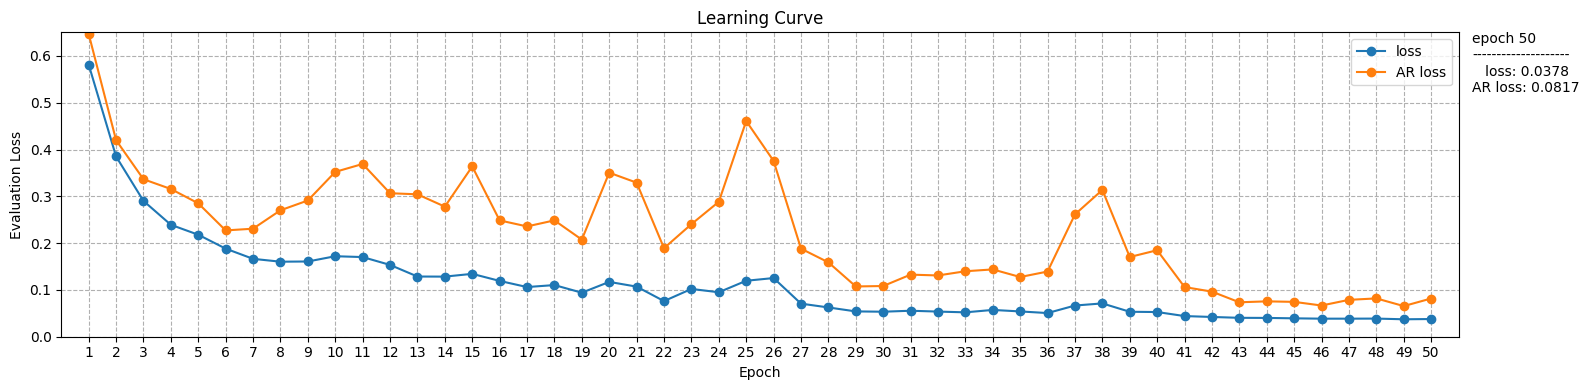

Epochs: 100%|██████████| 50/50 [13:59<00:00, 16.79s/epoch, loss: 0.0378, AR loss: 0.0817]


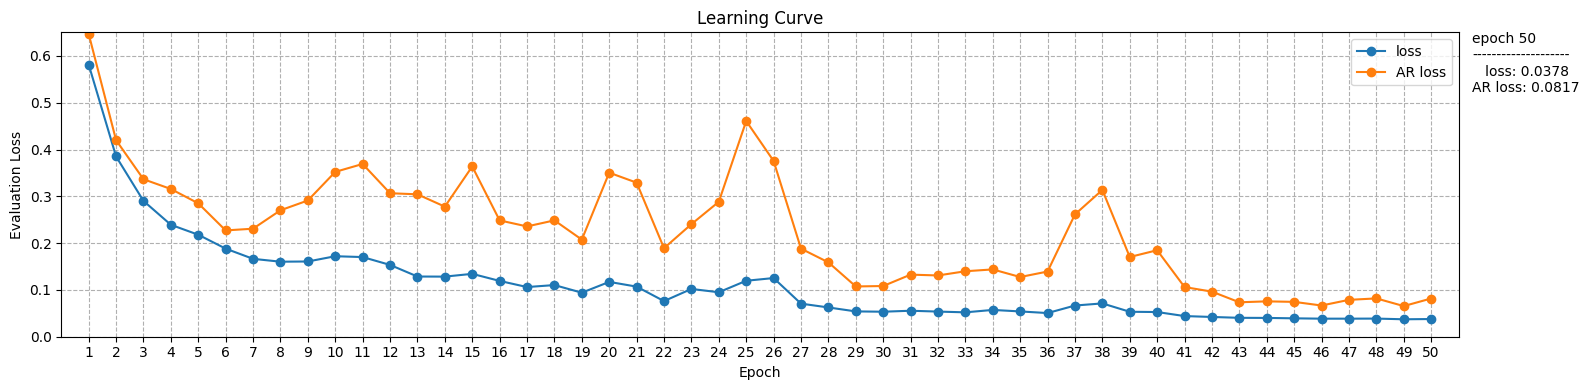

In [128]:
"""
Search for hyperparameters.
"""

model_config = dict(
    n_layers = 4,
    embed_dim = 128,
    num_heads = 4,
    norm_first = False, # try  changing this
    bias = True # try  changing this
    )

train_config = dict(
    optimizer_name = 'AdamW',
    optimizer_config = dict(),
    lr_scheduler_name = 'ReduceLROnPlateau',
    lr_scheduler_config = dict(factor=0.5, patience=3),

    n_epochs = 50,
    batch_size = 128,
    )

if __name__ == '__main__':
    train_dataset = Burgers_Dataset(device=Device)
    model = Model(**model_config)
    train(
        model = model, 
        train_dataset = train_dataset, 
        device = Device,
        plot_freq = 1,
        **train_config,
        )

## Visualize the results

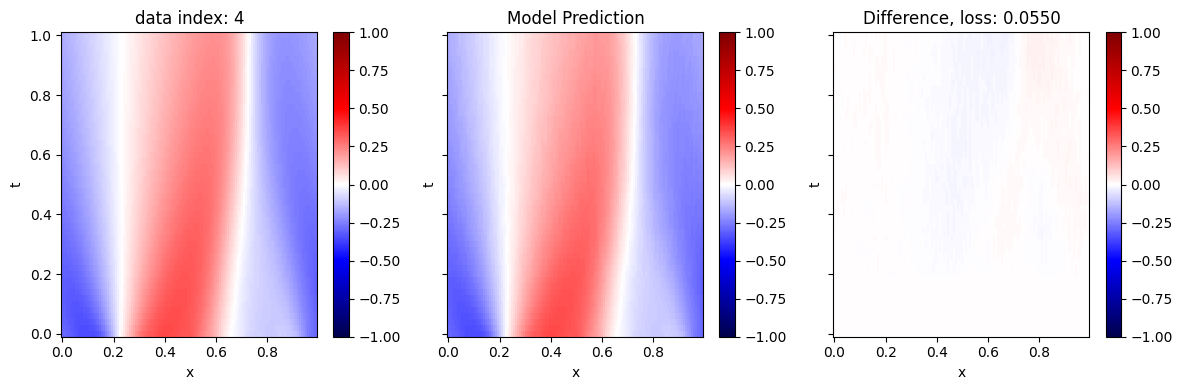

In [129]:
viz_burger(
    dataset = train_dataset, 
    idx = 4, # You can visualize different samples
    model = model, 
    loss_fn = rL2Loss, 
    n_starting_steps = 10,
    )

# Zip files for submission

In [130]:
from HW10_utils import save_yaml, load_yaml, zip_files


save_yaml(model_config, 'model_config.yaml')
save_yaml(train_config, 'train_config.yaml')
torch.save(model.cpu().state_dict(), 'state_dict.pt')

# try loading the model
model = Model(**load_yaml('model_config.yaml')).cpu()
model.load_state_dict(torch.load('state_dict.pt', map_location='cpu'))
print("Model can be loaded successfully!")

submission_files = ['HW10.ipynb', 'model_config.yaml', 'train_config.yaml', 'state_dict.pt']
zip_files('HW10_submission.zip', submission_files)

Model can be loaded successfully!
